In [1]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state
from ACS_data import colname_mask
import re
import pickle

pd.set_option('display.max_columns', None)

In [12]:
newacs = pd.read_csv("newACS.csv", index_col=0)
newacs['county_name'] = [newacs.index[x].split(",")[0] for x in range(len(newacs.index))]
newacs['State'] = [newacs.index[x].split(",")[1].split(":")[0][1:] for x in range(len(newacs.index))]
newacs['State'] = newacs['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
newacs['tot'] = 0
newacs['id'] = 0
newacs.head()


,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,people that are older than 65,median household income,median age,county_name,State,tot,id
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,4058,46650,41.9,Fayette County,IL,0,0
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,5224,57308,40.1,Logan County,IL,0,0
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,4785,44090,42.2,Saline County,IL,0,0
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,96339,89427,38.4,Lake County,IL,0,0
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,2962,47481,43.5,Massac County,IL,0,0


In [13]:
covid_cases = pd.read_csv('covid_confirmed_usafacts.csv')
covid_cases = covid_cases.rename(columns={'County Name':'county_name'})
covid_cases['county_name'] = covid_cases['county_name'].apply(lambda x: x.strip())
covid_cases.head()

# only cumulative
covid_cases = covid_cases[['countyFIPS','county_name','State','StateFIPS','2021-03-21']]



In [17]:
county_spending = get_county_spending()
county_spending = county_spending.rename(columns={'display_name':'county_name'})
county_spending['county_name'] = county_spending['county_name'].fillna('Missing')
county_spending['county_name'] = county_spending['county_name'].apply(lambda x: x + ' County')
county_spending = spend_county_state_map(county_spending, newacs, covid_cases)
county_spending['State'] = county_spending['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)

county_spending['log population'] = np.log(county_spending['population'])
county_spending['log amount'] = np.log(county_spending['amount'])
county_spending.head()

,amount,award_count,county_name,per_capita,population,shape_code,State,log population,log amount
0,3.732785e+10,801728,Los Angeles County,3718.24,10039107.0,06037,CA,16.121999,24.343006
1,1.025893e+10,449512,Miami-Dade County,3775.91,2716940.0,12086,FL,14.815017,23.051414
2,2.935259e+10,440440,Cook County,5699.27,5150233.0,17031,GA,15.454553,24.102647
3,1.508994e+10,302019,Harris County,3201.55,4713325.0,48201,GA,15.365904,23.437294
4,7.474192e+09,244141,Broward County,3827.47,1952778.0,12011,FL,14.484764,22.734722


In [ ]:
data = county_spending.dropna()
missing= len(county_spending.index) - len(data.index)
print("Number of missing vals: ", missing," - ", 100*missing/len(county_spending.index),"% of total")

In [119]:
import os
#os.dir()
os.chdir("/home/marylena/Documents/ConsultingProject")
print("finished chdir")
business = pd.read_csv("BusinessByCounty.csv", index_col=0).drop(index="id")
print("finished reading data, lenght", len(business.index))
business = business.iloc[np.where(business['NAICS2017_LABEL']=="Total for all sectors")[0],:]
business= business.iloc[np.where(business['LFO_LABEL']=="All establishments")[0],:]
business = business.iloc[np.where(business['EMPSZES_LABEL']=="All establishments")]
print("finished dropping, length",len(business.index))
business.head()


finished chdir
finished reading data, lenght 227294
finished dropping, length 3245


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N
GEO_ID,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G


In [120]:
business['county_name'] = [business.NAME[x].split(",")[0] for x in range(len(business.index))]
print("finished county name")
business['State'] =  [business.NAME[x].split(",")[len(business.NAME[x].split(","))-1][1:] for x in range(len(business.index))]
print("finished State 1")


business.head()

finished county name
finished State 1


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,county_name,State
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G,Autauga County,Alabama
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G,Baldwin County,Alabama
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,Alabama
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G,Bibb County,Alabama
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G,Blount County,Alabama


In [121]:
business['State'] = business['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
print("finished State 2")
business.head()

finished State 2


,GEO_ID_F,NAME,NAICS2017,NAICS2017_LABEL,SECTOR,NAICS2017_F,SUBSECTOR,INDLEVEL,INDGROUP,LFO,LFO_LABEL,EMPSZES,EMPSZES_LABEL,YEAR,ESTAB,PAYANN,PAYANN_N,PAYQTR1,PAYQTR1_N,EMP,EMP_N,county_name,State
GEO_ID,,,,,,,,,,,,,,,,,,,,,,,
0500000US01001,NaN,"Autauga County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,855,373865,G,90886,G,11397,G,Autauga County,AL
0500000US01003,NaN,"Baldwin County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,5507,2212640,G,517512,G,64354,G,Baldwin County,AL
0500000US01005,NaN,"Barbour County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,461,248131,G,60192,G,6980,G,Barbour County,AL
0500000US01007,NaN,"Bibb County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,293,145171,H,35475,H,3519,G,Bibb County,AL
0500000US01009,NaN,"Blount County, Alabama",00,Total for all sectors,00,NaN,NaN,2,NaN,001,All establishments,001,All establishments,2018,706,219763,G,52252,G,6673,G,Blount County,AL


In [148]:

#df= business.merge(data, how="left", on=["county_name","State"])
data=df.loc[:,["log population", "log amount", "ESTAB","PAYANN"]].dropna()

data.head()

,log population,log amount,ESTAB,PAYANN
0,10.930765,16.634995,855,373865
2,9.707533,17.128020,461,248131
3,10.113992,15.114805,461,248131
5,11.798766,18.992145,706,219763
6,10.965194,17.072026,706,219763


# Analysis

Text(0, 0.5, 'log amount')

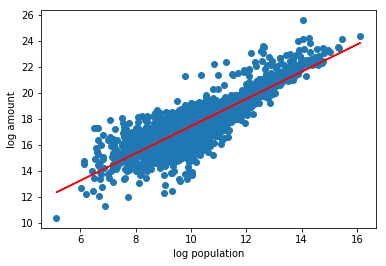

In [149]:
from matplotlib import pyplot as plt



plt.scatter('log population','log amount', data=data)
plt.plot(x, yhat, 'k-', color = 'r')
plt.xlabel('log population')
plt.ylabel('log amount')

Avg prediction error:  0.878703367352629


(array([1442.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1526.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

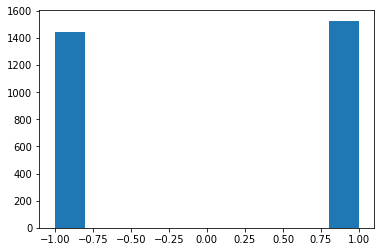

In [169]:
from sklearn import linear_model

y = np.asarray(data['log amount']).reshape(-1,1)
x=np.asarray(data['log population']).reshape(-1,1)

model = linear_model.LinearRegression().fit(x, y)

yhat = model.predict(x)
pred_error = np.sqrt(np.mean(np.subtract(yhat, y)**2))
print("Avg prediction error: ", pred_error)

outlying = np.zeros((len(data.index)))

for i in range(len(data.index)):
    #print(i)
    #print(data.iloc[i,:], "yhat: ",yhat[i])
    #print(y[i])
    if y[i]>= yhat[i] + 0*pred_error:
        outlying[i] = 1
    elif y[i]< yhat[i]-0*pred_error:
        outlying[i]=-1

plt.hist(outlying)

In [151]:
print(len(data.index), len(outlying))

2968 2968


In [170]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['ESTAB']=data.ESTAB.astype("int64")
data['PAYANN'] = data.PAYANN.astype("int64")
data['logESTAB'] = min_max_scaler.fit_transform(np.asarray(np.log(data.ESTAB)).reshape(-1,1))
data['logPAYANN'] = min_max_scaler.fit_transform(np.asarray(np.log(data.PAYANN)).reshape(-1,1))
data['logESTABlogPAYANN'] = data['logPAYANN']*data.logESTAB


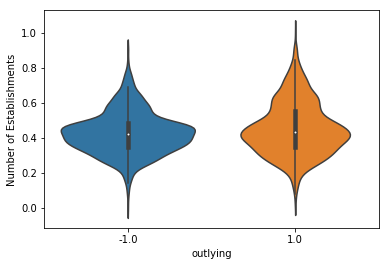

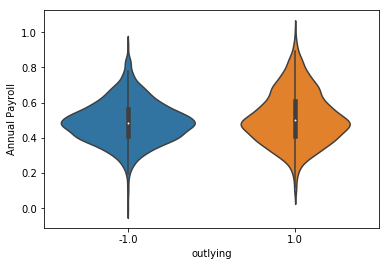

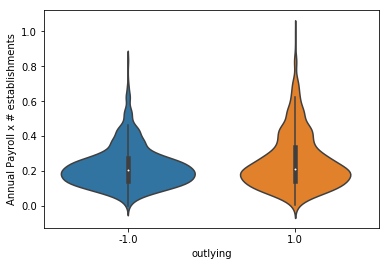

In [171]:
import seaborn as sns

data['outlying'] = outlying
sns.violinplot(x="outlying", y="logESTAB", data=data)
plt.ylabel("Number of Establishments")
plt.show()
sns.violinplot(x="outlying", y="logPAYANN", data=data)
plt.ylabel("Annual Payroll")
plt.show()
sns.violinplot(x="outlying", y="logESTABlogPAYANN", data=data)
plt.ylabel("Annual Payroll x # establishments")
plt.show()